<a href="https://colab.research.google.com/github/inachenyx/SpeechSNN/blob/main/SR_snnTorch_encode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 4.7 MB/s eta 0:00:00


In [2]:
import os
import io
import numpy as np
import pandas as pd
import snntorch as snn
import torch
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt

### Upload local data file (should all be raw bytes)

In [3]:
from google.colab import files
uploaded = files.upload()

Saving ae.train to ae.train
Saving ae.test to ae.test
Saving size_ae.train to size_ae.train
Saving size_ae.test to size_ae.test


In [4]:
# List uploaded files
os.listdir()

['.config',
 'ae.train',
 'size_ae.train',
 'ae.test',
 'size_ae.test',
 'sample_data']

In [5]:
# # !!!ONLY remove files from previous upload AS NEEDED!!!
# files_to_remove = ['size_ae (1).train', 'ae (1).test', 'size_ae (1).test']
# for fname in files_to_remove:
#     if os.path.exists(fname):
#         os.remove(fname)

# # Check that they're gone
# print(os.listdir())

### Read and explore data from uploaded file

In [13]:
with open("ae.train", "rb") as f:
    train_data = f.read()
print(train_data[:100]) # contains space-separated float values
print(type(train_data)) # <class 'bytes'> raw bytes

with open("ae.test", "rb") as f:
    test_data = f.read()
print(test_data[:100]) # contains space-separated float values
print(type(test_data)) # <class 'bytes'> raw bytes

with open("size_ae.train", "rb") as f:
    train_label_counts = f.read()
print(train_label_counts) # contains space-separated float values
print(type(train_label_counts)) # <class 'bytes'> raw bytes

with open("size_ae.test", "rb") as f:
    test_label_counts = f.read()
print(test_label_counts) # contains space-separated float values
print(type(test_label_counts)) # <class 'bytes'> raw bytes

b'1.860936 -0.207383 0.261557 -0.214562 -0.171253 -0.118167 -0.277557 0.025668 0.126701 -0.306756 -0.2'
<class 'bytes'>
b'1.635533 0.024848 0.432087 -0.361914 -0.074776 -0.693481 -0.229621 0.261503 -0.089421 -0.020431 -0.0'
<class 'bytes'>
b'30 30 30 30 30 30 30 30 30\n'
<class 'bytes'>
b'31 35 88 44 29 24 40 50 29 \n'
<class 'bytes'>


### Function that prepares data for latency encoding

In [7]:
def prepare_spike_data(byte_data, label_counts):
    """Parses raw byte input, assigns speaker labels, pads sequences, and normalizes.

    Args:
        - byte_data (bytes): raw byte input read from ae.train, ae.test
        - label_counts (List[int]): each element represents how many blocks belong to a speaker

    Returns:
        - torch.Tensor of shape (N, 12, T): padded and normalized data
        - torch.Tensor of shape (N,): speaker labels
        - int: maximum sequence length (T)
    """
    # Step 1: Decode bytes to string
    text = byte_data.decode("utf-8")

    # Step 2: Split into blocks by blank lines
    blocks = [b.strip() for b in text.strip().split("\n\n") if b.strip()]
    # .strip() removes any leading/trailing blank lines; split at double new lines; "if b.strip()" is True if the stripped string is not empty, and False if it is empty.
    # Type: List[str], a clean list of strings, each string contains one block representing one sample/utterance

    data_blocks = [] # eventually a List[np.ndarray]
    labels = [] # one label per block

    index = 0
    for speaker_id, count in enumerate(label_counts, start=1):  # speaker labels start at 1
        for _ in range(count): # sample size = number of blocks
            lines = blocks[index].splitlines() # a list of substrings, divided using line breaks as delimiters
            frame_data = [list(map(float, line.strip().split())) for line in lines] # for each line, further split to strings of single numbers, divided using whitespaces, e.g., "1.2 2.3 3.4" → ["1.2", "2.3", "3.4"]
            # and map the list of strings to a list of floats, e.g.["1.2", "2.3", "3.4"] → [1.2, 2.3, 3.4]; produces a list of lists → a 2D array, shape: (T,12)
            data_blocks.append(np.array(frame_data))  # forms a list of (T, 12) arrays
            labels.append(speaker_id)
            index += 1

    # Step 3: Determine max time length for padding
    max_len = max([block.shape[0] for block in data_blocks])

    # Step 4: Pad sequences with zeros to max_len
    padded_blocks = []
    for block in data_blocks:
        T = block.shape[0]
        if T < max_len:
            pad = np.zeros((max_len - T, block.shape[1]))
            block = np.vstack([block, pad]) # (max_len, 12) array
        padded_blocks.append(block) # list of (max_len, 12) arrays

    padded_array = np.stack(padded_blocks)  # shape: (N, T, 12)

    # Step 5: Normalize all features to 0-1 using MinMaxScaler
    N, T, F = padded_array.shape
    scaler = MinMaxScaler()
    flat = padded_array.reshape(-1, F)
    normalized = scaler.fit_transform(flat).reshape(N, T, F)

    # Step 6: Convert to torch tensor and permute to (N, 12, T)
    data_tensor = torch.tensor(normalized, dtype=torch.float32).permute(0, 2, 1) # changes the shape from (N, T, 12) to (N, 12, T)
    label_tensor = torch.tensor(labels, dtype=torch.long)

    return data_tensor, label_tensor, max_len

In [8]:
with open("ae.train", "rb") as f:
    train_bytes = f.read()

with open("ae.test", "rb") as f:
    test_bytes = f.read()

train_counts = [30] * 9
test_counts = [31, 35, 88, 44, 29, 24, 40, 50, 29]

X_train, y_train, train_T = prepare_spike_data(train_bytes, train_counts)
X_test, y_test, test_T = prepare_spike_data(test_bytes, test_counts)

print(X_train.shape)  # (270, 12, train_T)
print(y_train.shape)  # (270,)
print(train_T)
print(test_T)

torch.Size([270, 12, 26])
torch.Size([270])
26
29


In [9]:
import snntorch.spikegen as spikegen

spike_train = spikegen.latency(X_train, num_steps=100, tau=5, threshold=0.01, normalize=True, linear=True)
# higher tau -> slower firing,
print(spike_train.shape)

torch.Size([100, 270, 12, 26])


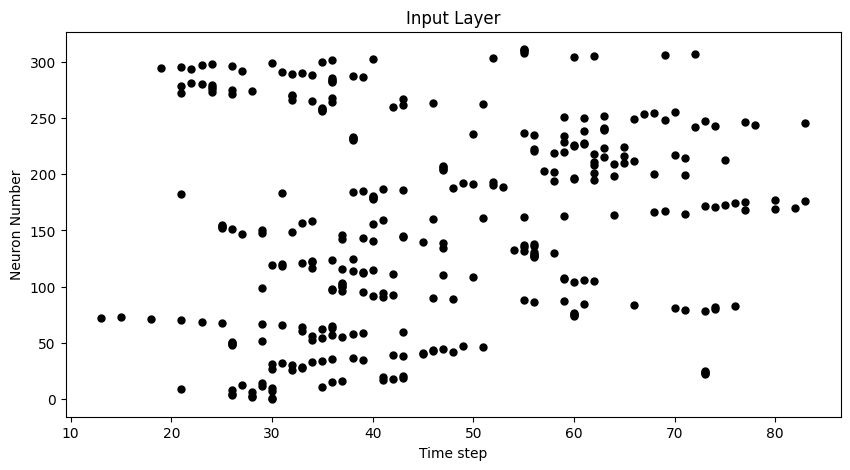

In [14]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_train[:, 6].view(100, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

In [11]:
print(spike_train[:, 6].shape)

torch.Size([100, 12, 26])


In [12]:
# Decode the bytes to a string
decoded = test_data.decode('utf-8')

# Wrap it in a StringIO buffer so pandas can read it like a file
df = pd.read_csv(io.StringIO(decoded), sep='\s+', header=None) # separate by space

print(df.head(40))
print(df.shape)

          0         1         2         3         4         5         6   \
0   1.635533  0.024848  0.432087 -0.361914 -0.074776 -0.693481 -0.229621   
1   1.547694  0.008754  0.319101 -0.297440 -0.007617 -0.636042 -0.296480   
2   1.602593 -0.210520  0.280175 -0.233207 -0.024576 -0.592074 -0.239185   
3   1.672665 -0.343458  0.263109 -0.167267  0.043357 -0.564522 -0.286775   
4   1.748497 -0.404425  0.238913 -0.152473  0.135756 -0.513615 -0.339162   
5   1.870264 -0.547399  0.248318 -0.170991  0.121421 -0.418381 -0.276134   
6   1.682187 -0.401484  0.093114 -0.119936  0.102706 -0.358395 -0.204987   
7   1.745937 -0.417672  0.179397 -0.282905  0.235438 -0.350983 -0.195268   
8   1.453572 -0.286032  0.186518 -0.237188  0.322850 -0.245160 -0.276801   
9   1.416367 -0.410469  0.352763 -0.211245  0.354378 -0.165260 -0.328168   
10  1.466251 -0.385350  0.294102 -0.109096  0.418092 -0.220405 -0.328038   
11  1.515589 -0.370543  0.357567 -0.050578  0.379828 -0.207061 -0.333240   
12  1.321718